# GNDVI for Nitrogen Content

Opening bands with rasterio

In [1]:
import rasterio as rio
BANDS='S2B_MSIL2A_20220103T101319_N0301_R022_T30NZM_20220103T130628.SAFE\GRANULE\L2A_T30NZM_A025216_20220103T101650\IMG_DATA\R10m'
B3_GREEN=rio.open(BANDS+'/T30NZM_20220103T101319_B03_10m.jp2')
B8_NIR=rio.open(BANDS+'/T30NZM_20220103T101319_B08_10m.jp2')


Computation of GNDVI and storing in a TIF file

In [2]:
import numpy
numpy.seterr(divide='ignore',invalid='ignore')
GREEN=B3_GREEN.read()
NIR=B8_NIR.read()
GNDVI=(NIR.astype(float)-GREEN.astype(float))/(NIR+GREEN)

meta=B3_GREEN.meta
print(meta)
GNDVI_type=GNDVI.dtype
print(GNDVI_type)


kwargs=meta

kwargs=meta

kwargs.update(dtype=GNDVI_type)
kwargs.update(count=1)
kwargs.update(driver='GTiff')

with rio.open('GNDVI_data/GNDVI.tif','w',**kwargs) as dst:
    dst.write(GNDVI)
    

{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32630), 'transform': Affine(10.0, 0.0, 799980.0,
       0.0, -10.0, 700020.0)}
float64


Opening Shapefile

In [3]:
import geopandas as gpd
nReserve=gpd.read_file('shapefile/Kpong_Reservoir-polygon.shp')



Using shapefile to clip the data to have only the water body and storing the new data

In [4]:
from rasterio.mask import mask
nReserve_proj=nReserve.to_crs('epsg:32630')

with rio.open("GNDVI_data/GNDVI.tif") as src:
    out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rio.open("GNDVI_data/GNDVI_masked.tif","w",**out_meta) as dest:
    dest.write(out_image)

In [5]:
image_file="GNDVI_data/GNDVI_masked.tif"
GNDVII=rio.open(image_file)
GNDVIRI=GNDVII.read()

Class written by Joe Kington to Normalize the colorbar

In [6]:
from matplotlib import colors

# Credit: Joe Kington
class MidpointNormalize(colors.Normalize):
    """
    Normalize the colorbar so that diverging bars work there way either side from a prescribed midpoint value
    
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return numpy.ma.masked_array(numpy.interp(value, x, y), numpy.isnan(value))

In [7]:
print(numpy.nanmin(GNDVIRI))
print(numpy.nanmax(GNDVIRI))
print(numpy.nanmean(GNDVIRI))
print(numpy.std(GNDVIRI))


-0.22939560439560439
0.5288118306986231
-0.0587754876915526
0.07703910779153567


Attaining the colormap plot

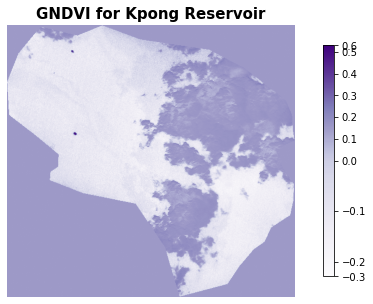

In [8]:
import matplotlib.pyplot as plt

min=numpy.nanmin(GNDVIRI)
max=numpy.nanmax(GNDVIRI)

mid=0.0
colormap=plt.cm.Purples
norm= MidpointNormalize(vmin=min,vmax=max,midpoint=mid)
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
GNDVIRI=GNDVIRI.squeeze()
cbar_plot=ax.imshow(GNDVIRI, cmap=colormap, norm=norm)
ax.axis('off')
cbar=fig.colorbar(cbar_plot,orientation='vertical',shrink=0.85)
ax.set_title('GNDVI for Kpong Reservoir',fontsize=15,fontweight='bold')
fig.savefig("GNDVI_data/gndvi-fig",dpi=200,bbox_inches='tight',pad_inches=0.7)


Attaining the Histogram Plot

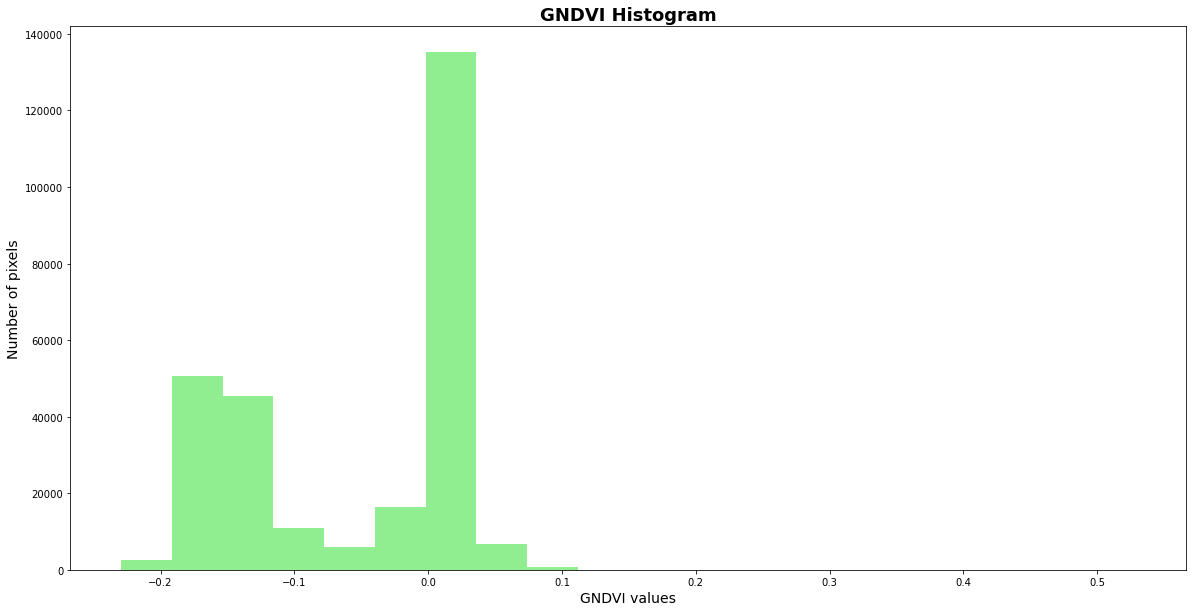

In [9]:
fig2 = plt.figure(figsize=(20,10))
ax = fig2.add_subplot(111)
plt.title("GNDVI Histogram", fontsize=18, fontweight='bold')
plt.xlabel("GNDVI values", fontsize=14)
plt.ylabel("Number of pixels", fontsize=14)
x = GNDVIRI[~numpy.isnan(GNDVIRI)]
bins = 20
color = 'lightgreen'
ax.hist(x,bins,color=color)
fig2.savefig("GNDVI_data/gndvi-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.7)
plt.show()

In [10]:
fig.savefig(r"C:\xampp\htdocs\SourceCode/gndvi-fig_20220103T101319.png", dpi=200,bbox_inches='tight',pad_inches=0.7)
fig2.savefig(r"C:\xampp\htdocs\SourceCode/gndvi-histogram_20220103T101319.png",dpi=200,bbox_inches='tight',pad_inches=0.7)

Forwarding the Information to the Database

In [11]:
import mysql.connector
from mysql.connector import Error

In [12]:
x=0
try:
    connection=mysql.connector.connect(host='localhost',database='remotesensingdata',user='root',password='')

    
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version ", db_Info)
        cursor = connection.cursor()
        cursor.execute("select database();")
        record = cursor.fetchone()
        print("You're connected to database: ", record)
        x=x+1

except Error as e:
    print("Error while connecting to MySQL", e)

Connected to MySQL Server version  5.5.5-10.4.22-MariaDB
You're connected to database:  ('remotesensingdata',)


In [13]:
Id='20220103T101319'
MinGNDVI=float(numpy.nanmin(GNDVIRI))
MaxGNDVI=float(numpy.nanmax(GNDVIRI))
MeanGNDVI=float(numpy.nanmean(GNDVIRI))
StdGNDVI=float(numpy.nanstd(GNDVIRI))

In [14]:
connection=mysql.connector.connect(host='localhost',database='remotesensingdata',user='root',password='')

cursor=connection.cursor()
cursor.execute("INSERT INTO nitrogencontent (DatasetID, GNDVIMean, GNDVIMax, GNDVIMin, StandardDeviation) VALUES(%s, %s, %s, %s, %s)", (Id,MeanGNDVI,MaxGNDVI,MinGNDVI,StdGNDVI))
connection.commit()
print(cursor.rowcount,"Record insert successfully in to Table")

cursor.close()

1 Record insert successfully in to Table


True

In [15]:
Id='20220103T101319'
Figure='GNDVI_data/gndvi-fig.png'
Histogram='GNDVI_data/gndvi-histogram.png'
FigureName="gndvi-fig_20220103T101319.png"
HistName="gndvi-histogram_20220103T101319.png"


In [16]:
import mysql.connector
connection=mysql.connector.connect(host='localhost',database='remotesensingdata',user='root',password='')

def convertToBinaryData(filename):
    with open(filename,'rb') as file:
        binaryData=file.read()
    return binaryData

In [17]:
def INSERTPIC(ID,FIG,HIST,FIGONE,HISTONE):
    connection=mysql.connector.connect(host='localhost',database='remotesensingdata',user='root',password='')
    C=connection.cursor()
    
    Figpic=convertToBinaryData(FIG)
    Histpic=convertToBinaryData(HIST)
    
    C.execute("INSERT INTO nitrogencontentimages (DatasetID,GNDVIfig,GNDVIhistogram,GNDVIFigName,GNDVIHistName) VALUES(%s,%s,%s,%s,%s)",(ID,Figpic,Histpic,FIGONE,HISTONE))
    
    connection.commit()
    print(C.rowcount,"Record insert successfully in to Table")

    C.close()

In [18]:
INSERTPIC(Id,Figure,Histogram,FigureName,HistName)

1 Record insert successfully in to Table
